In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch

from bo_functions import ExactGPModel
from bo_functions import train_GP_model
# from bo_functions import eval_GP_components
from bo_functions import create_y_data
from bo_functions import bo_iter
from bo_functions import test_train_split
from bo_functions import bo_iter_w_restarts

from bo_plotters import plot_hyperparams
# from bo_plotters import sse_plotter
# from bo_plotters import stdev_plotter
# from bo_plotters import ei_plotter_adv_test
# from bo_plotters import ei_plotter
from bo_plotters import plot_xy
from bo_plotters import error_plotter_4D
from bo_plotters import y_plotter_4D
from bo_plotters import stdev_plotter_4D

In [2]:
#Pull x and Y data from CSV
#Pull x data from CSV
#Set Parameters
Theta_True = np.array([1,-1])
BO_iters = 15
iterations = 300
train_iter = 300
noise_std=0.1

emulator = True
verbose = False
sparse_grid = False

shuffle_seed = 6
t=4

explore_bias = torch.tensor([0.5])

#Pull Experimental data from CSV
exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)

#Define GP Testing space
p=20
Theta1 =  np.linspace(0.5,1.5,p) #1x10
Theta2 =  np.linspace(-1.5,-0.5,p) #1x10
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta1_mesh = theta_mesh[0]
theta2_mesh = theta_mesh[1]

# print(theta_mesh.shape[1])

Explore Bias: tensor(0.5000)
Magnitude of SSE given Theta_Opt =  [ 0.82324468 -0.8958694 ] is 6.8439e-01


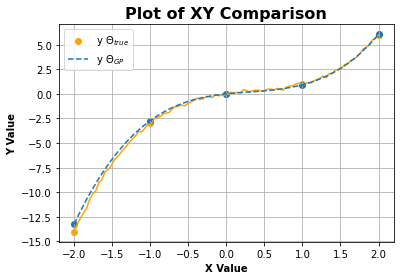

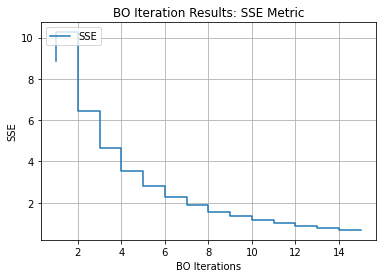

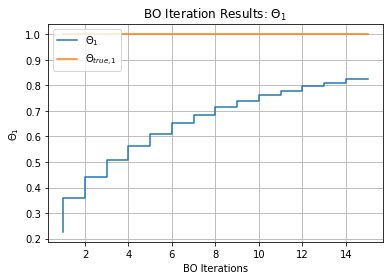

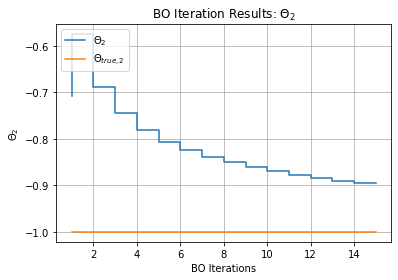

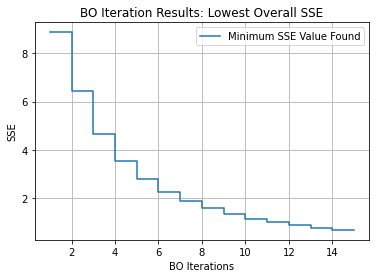

In [5]:
#Create training and test data
##Objective function = SSE
##USING SCIPY METHOD
##Uses 20 LHS Training points
save_fig=False
obj = "obj"
restarts = 0

#Set 20 Point Training data, Model, and Likelihood
#Pull training data from CSV
#Separate training and testing data, uses default of an 80%/20% split
all_data_doc = "all_3_data.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))
train_data, test_data = test_train_split(all_data, shuffle_seed=shuffle_seed)
train_p = train_data[:,1:(len(Theta_True)+Xexp[0].size+1)]
train_y = train_data[:,-1]

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_p, train_y, likelihood)

for i in range(len(explore_bias)):
    print("Explore Bias:", explore_bias[i])
    BO_Results = bo_iter(BO_iters,train_p,train_y,theta_mesh,Theta_True,train_iter,explore_bias[i], Xexp, Yexp, noise_std, 
                         obj, restarts, sparse_grid, emulator, verbose = verbose,save_fig=save_fig)
    if verbose == True:
        print("Exploration Parameter:",explore_bias[i] )
        print("Best_GP_Theta \n",BO_Results[0])
        print("\n Optimal_GP_Theta \n",BO_Results[1])
        print("\n Total SSE \n", BO_Results[2], "\n")

Explore Bias: tensor(0.5000)
Restart Number:  1


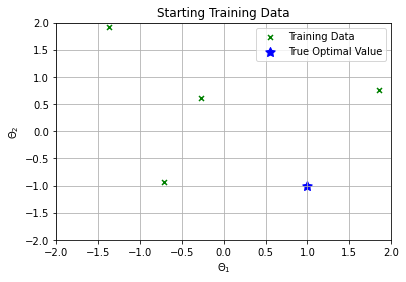

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Magnitude of SSE given Theta_Opt =  [-0.77713667  0.71386484] is 1.3163e+02
Restart Number:  2


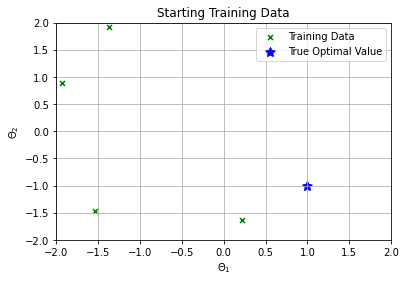

Magnitude of SSE given Theta_Opt =  [-1.61835584  1.52922951] is 2.8632e+02
Restart Number:  3


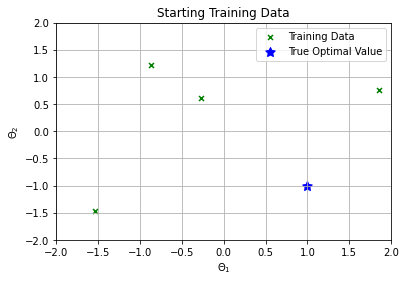

Magnitude of SSE given Theta_Opt =  [ 0.71525465 -0.76674958] is 2.6803e+00


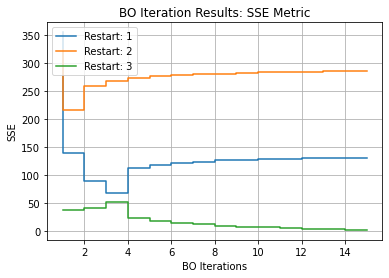

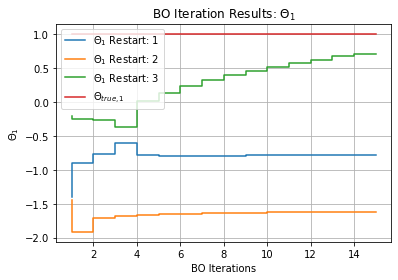

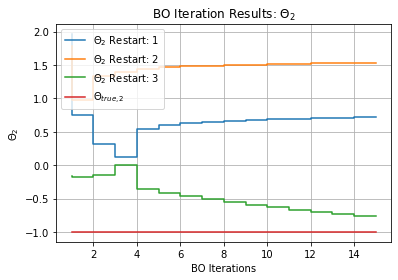

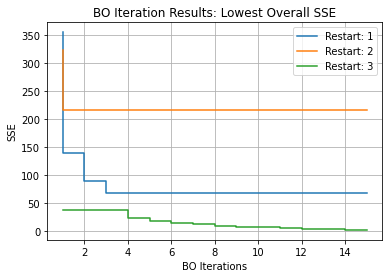

The GP predicts that the lowest SSE of 2.680e+00 occurs at θ = [[ 0.71525465 -0.76674958]] during restart 3


In [3]:
save_fig=False
obj = "obj"
restarts = 3

all_data_doc = "all_3_data.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))   

for i in range(len(explore_bias)):
    print("Explore Bias:", explore_bias[i])
    results = bo_iter_w_restarts(BO_iters,all_data_doc,t,theta_mesh,Theta_True,train_iter,explore_bias[i], Xexp, Yexp,
                                 noise_std, obj, restarts, sparse_grid, emulator, verbose,save_fig, shuffle_seed)
    print("The GP predicts that the lowest SSE of", "{:.3e}".format(results[2]), "occurs at \u03B8 =", results[1], "during restart", results[0])

## Analysis of Standard Deviation
 - The GP estimates that the standard deviation is lowest at points that were directly tested
  - This can be rationalized by the way that the contour plot is drawn
 - Standard deviation is smallest away from the edges and larger towards them
  - This is rationalized by the fact that there are less neighbors that the GP is tested and trained with at the boundaries
 - The more points that get tested, the more the standard deviations will decrease

## Analysis of Error Squared Magnitude
 - The GP emulator is most inaccurate when all values of $\bar{p}$ are at their extreme points 
  - In general, the GP is less accurate at extreme points, this is rationalized by the fact that there are less neighbors that the GP is tested and trained with at the boundaries
 - The GP emulator is most accurate after convergence
 - GP error is mostly very low, as more iterations are added, error decreases

## Analysis of GP Emulator (Model y)
 - The GP emulator correctly captures that y increases as $\bar{p}$ increases. This tells us that this GP emulator model could be viable
  - The GP emulator suitably estimates where the lowest y is achieved and the actual value of y
  - Slight error leads to small inaccuracies in the value of $\bar{\theta}$ and the values of y